In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microtext/Dataset - tachygraphy.csv


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
df=pd.read_csv("/kaggle/input/microtext/Dataset - tachygraphy.csv")
df.shape

(4958, 3)

In [31]:
df.head()

,Text,Meaning,Sentiment
0,Last session of the day http://twitpic.com/67ezh,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely --...,Shanghai is also really exciting (precisely --...,positive
2,submit the report ASAP!,submit the report as soon as possilbe,negative
3,happy bday!,Happy Birthday!,positive
4,The OGs - I like it!!,The original gangsters - i like it!,positive


In [9]:
df=df.drop('Meaning',axis=1)

In [32]:
df.shape

(4958, 3)

In [11]:
df = df.rename(columns={'Text': 'tweet'})

In [12]:
df = df.rename(columns={'Sentiment': 'class'})

In [13]:
df['class'] = df['class'].str.lower()
sentiment_counts = df['class'].value_counts()
sentiment_counts

class
neutral     1743
positive    1643
negative    1572
Name: count, dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])
encoded_labels = label_encoder.transform(df['class'])
df['class'] = encoded_labels

In [33]:
df.isnull().sum()

Text         1
Meaning      1
Sentiment    0
dtype: int64

In [34]:
df=df.fillna('')

In [35]:
df.head()

,Text,Meaning,Sentiment
0,Last session of the day http://twitpic.com/67ezh,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely --...,Shanghai is also really exciting (precisely --...,positive
2,submit the report ASAP!,submit the report as soon as possilbe,negative
3,happy bday!,Happy Birthday!,positive
4,The OGs - I like it!!,The original gangsters - i like it!,positive


In [36]:
import re
from bs4 import BeautifulSoup

def text_cleaning(text):
    text = str(text)
    soup = BeautifulSoup(text, "html.parser")    ###removing html tages
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())      ##removing text within square brackets
    pattern = r"[^a-zA-Z0-9\s,']"                  # Removing unwanted characters
    text = re.sub(pattern, '', text)
    url_pattern = r'http\S+|www\S+'            ###removing urls
    text = re.sub(url_pattern, '', text)
    return text

In [38]:
df['Text'] = df['Text'].apply(text_cleaning).tolist()

/tmp/ipykernel_34/2827669698.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")    ###removing html tages


In [39]:
df['Meaning'] = df['Meaning'].apply(text_cleaning).tolist()

/tmp/ipykernel_34/2827669698.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")    ###removing html tages


In [20]:
df.head(10)

,tweet,class
0,Last session of the day,1
1,Shanghai is also really exciting precisely sk...,2
2,submit the report ASAP,0
3,happy bday,2
4,The OGs I like it,2
5,thats great weee visitors,2
6,I THINK EVERYONE HATES ME ON HERE lol,0
7,"soooooo wish i could, but im in school and mys...",0
8,and within a short time of the last clue all o...,1
9,What did you get My day is alright havent done...,1


In [40]:
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

In [41]:
df['Meaning'] = df['Meaning'].apply(remove_URL).tolist()

In [23]:
lens=[len(i.split()) for i in df['tweet']]

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Emotion labels corresponding to the GoEmotions dataset
emotions = ["admiration", "amusement", "anger", "annoyance", "approval", 
            "caring", "confusion", "curiosity", "desire", "disappointment", 
            "disapproval", "disgust", "embarrassment", "excitement", 
            "fear", "gratitude", "grief", "joy", "love", "nervousness", 
            "optimism", "pride", "realization", "relief", "remorse", 
            "sadness", "surprise"]

# Define a function to classify a text input
def classify_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert logits to probabilities
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # Get the predicted emotion
    predicted_emotion = emotions[torch.argmax(probabilities)]
    
    return predicted_emotion

# Apply the model to each text in the dataset
df['predicted_emotion'] = df['tweet'].apply(classify_emotion)

# Save the dataset with the new column
df.to_csv('dataset_with_emotions.csv', index=False)

# Preview the dataset with the new column
print(df.head())

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

                                               tweet  class predicted_emotion
0                           Last session of the day       1         annoyance
1  Shanghai is also really exciting precisely  sk...      2         amusement
2                             submit the report ASAP      0         amusement
3                                         happy bday      2         amusement
4                                 The OGs  I like it      2         amusement


In [43]:
from senticnet.senticnet import SenticNet
import pandas as pd

# Initialize SenticNet
sn = SenticNet()

# Define a function to extract emotions from text using SenticNet
def classify_emotion_with_senticnet(text):
    words = text.split()
    emotions_detected = []

    for word in words:
        try:
            # Get the sentic concepts associated with the word
            sentic_info = sn.concept(word)
            primary_emotion = sentic_info['primary_mood']
            secondary_emotion = sentic_info['secondary_mood']
            
            # Add the detected emotions to the list
            emotions_detected.append(primary_emotion)
            emotions_detected.append(secondary_emotion)
        except KeyError:
            # Skip words that are not in SenticNet
            continue
    
    # Return the most common emotion or emotions detected in the text
    if emotions_detected:
        return max(set(emotions_detected), key=emotions_detected.count)
    else:
        return "neutral"  # Default to neutral if no emotion is detected

# Apply the function to classify emotions in the dataset
df['emotion_senticnet'] = df['Meaning'].apply(classify_emotion_with_senticnet)

# Save the updated dataset to a new CSV file
df.to_csv('dataset_with_emotions_senticnet.csv', index=False)

# Preview the dataset with the new column
print(df.head())


                                                Text  \
0                           Last session of the day    
1  Shanghai is also really exciting precisely  sk...   
2                             submit the report ASAP   
3                                         happy bday   
4                                 The OGs  I like it   

                                             Meaning Sentiment  \
0                           Last session of the day    neutral   
1  Shanghai is also really exciting precisely  sk...  positive   
2              submit the report as soon as possilbe  negative   
3                                     Happy Birthday  positive   
4                  The original gangsters  i like it  positive   

  emotion_senticnet  
0           neutral  
1           neutral  
2           neutral  
3           neutral  
4           neutral  


In [45]:
from senticnet.senticnet import SenticNet
import pandas as pd
import re
from itertools import islice

# Initialize SenticNet
sn = SenticNet()

# Preprocessing function to clean text
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

# Function to extract n-grams from text
def extract_ngrams(text, n):
    words = text.split()
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

# Function to classify emotion using SenticNet with improved concept extraction
def classify_emotion_with_senticnet(text):
    # Preprocess the text
    text = preprocess_text(text)
    
    # Check for multi-word concepts (up to 4-grams)
    max_n = 4
    emotions_detected = []

    for n in range(max_n, 0, -1):  # Start with the largest n-grams
        ngrams = extract_ngrams(text, n)
        for ngram in ngrams:
            try:
                # Get the sentic concepts associated with the n-gram
                sentic_info = sn.concept(ngram)
                primary_emotion = sentic_info['primary_mood']
                secondary_emotion = sentic_info['secondary_mood']
                
                # Add the detected emotions to the list
                emotions_detected.append(primary_emotion)
                emotions_detected.append(secondary_emotion)
                
                # If an emotion is detected, stop further searching
                break
            except KeyError:
                continue

        if emotions_detected:
            break

    # Return the most common emotion detected, or neutral if none found
    if emotions_detected:
        return max(set(emotions_detected), key=emotions_detected.count)
    else:
        return "neutral"

# Apply the function to classify emotions in the dataset
df['emotion_senticnet'] = df['Meaning'].apply(classify_emotion_with_senticnet)

# Save the updated dataset to a new CSV file
df.to_csv('dataset_with_emotions_senticnet.csv', index=False)

# Preview the dataset with the new column
print(df.head())


                                                Text  \
0                           Last session of the day    
1  Shanghai is also really exciting precisely  sk...   
2                             submit the report ASAP   
3                                         happy bday   
4                                 The OGs  I like it   

                                             Meaning Sentiment  \
0                           Last session of the day    neutral   
1  Shanghai is also really exciting precisely  sk...  positive   
2              submit the report as soon as possilbe  negative   
3                                     Happy Birthday  positive   
4                  The original gangsters  i like it  positive   

  emotion_senticnet  
0           neutral  
1           neutral  
2           neutral  
3           neutral  
4           neutral  


In [53]:
import pandas as pd
from senticnet.senticnet import SenticNet
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
import re

sn = SenticNet()


In [46]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from stop_words import get_stop_words

def remove_stopwords(text1):
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords
    stop_words.extend(nltk_words)
    
    output = [w for w in text1 if not w in stop_words]

In [47]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    tokenized_text = word_tokenize(text)
    return tokenized_text

In [51]:
def get_moodtags(text1):
    emotion_list = []

    for word in text1:
        try:
            emotion_list.append(sn.moodtags(word))
        except: continue
        
    print(emotion_list)

In [54]:
txtc = df['Text'][0]
print(txtc)
txct = text_cleaning(txtc)
txtc = tokenize(txtc)
print(txtc)
txtc = remove_stopwords(txtc)
print(txtc)
get_moodtags(txtc)

Last session of the day 
['Last', 'session', 'of', 'the', 'day']
None


TypeError: 'NoneType' object is not iterable

In [28]:
!pip install senticnet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 MB 30.5 MB/s eta 0:00:00:00:0100:01


(array([ 267.,  805.,  991., 1078.,  570.,  465.,  489.,  215.,   67.,
          11.]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ]),
 <BarContainer object of 10 artists>)

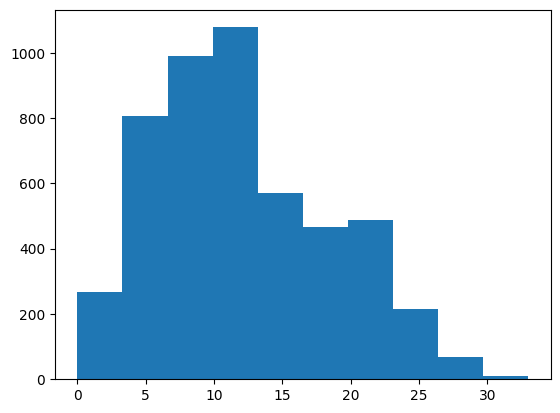

In [22]:
import matplotlib.pyplot as plt
plt.hist(lens)

In [23]:
import torch
import torch.nn as nn

import transformers
from transformers import AutoModel, BertTokenizerFast

In [24]:
# split into train, validation and test sets in the ration 70 : 15 : 15
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['class'], 
                                                                    random_state=2021, 
                                                                    test_size=0.3, 
                                                                    stratify=df['class'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2021, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [25]:
bert = AutoModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification

(array([192., 555., 679., 745., 409., 339., 340., 158.,  46.,   7.]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ]),
 <BarContainer object of 10 artists>)

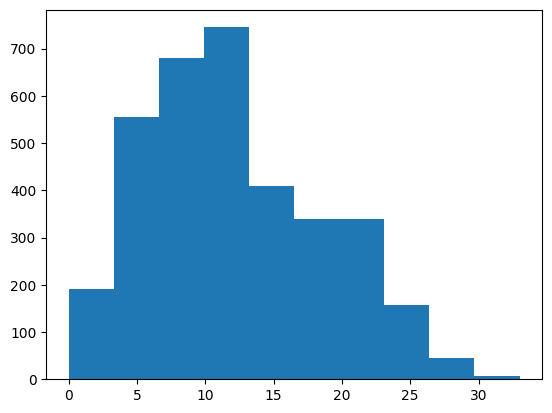

In [28]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

In [29]:
pad_len=18        #higher padding length means longer sentences will not be truncated 

In [30]:
import pandas as pd

sequence_lengths = df['tweet'].apply(lambda x: len(x.split()))
print(sequence_lengths.describe())


count    4958.000000
mean       12.075635
std         6.410801
min         0.000000
25%         7.000000
50%        11.000000
75%        17.000000
max        33.000000
Name: tweet, dtype: float64


In [31]:
pd_len = sequence_lengths.quantile(0.80)
print(f"Padding length: {pd_len}")

Padding length: 18.0


In [42]:
# tokenize and encode sequences 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [43]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [33]:

for param in bert.parameters():
    param.requires_grad = False

In [32]:


def personality_detection(text):
    tokenizer = BertTokenizer.from_pretrained("Minej/bert-base-personality")
    model = BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.squeeze().detach().numpy()

    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result = {label_names[i]: predictions[i] for i in range(len(label_names))}

    return result


In [41]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Initialization of the model values
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

model.config.label2id = {
    "Extroversion": 0,
    "Neuroticism": 1,
    "Agreeableness": 2,
    "Conscientiousness": 3,
    "Openness": 4,
}
model.config.id2label = {
    "0": "Extroversion",
    "1": "Neuroticism",
    "2": "Agreeableness",
    "3": "Conscientiousness",
    "4": "Openness",
}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:


def personality_detection_cust(model_input: str) -> dict:
    '''
    Performs personality prediction on the given input text

    Args: 
        model_input (str): The text conversation 

    Returns:
        dict: A dictionary where keys are speaker labels and values are their personality predictions
    '''

    if len(model_input) == 0:
        ret = {
            "Extroversion": float(0),
            "Neuroticism": float(0),
            "Agreeableness": float(0),
            "Conscientiousness": float(0),
            "Openness": float(0),
        }
        return ret
    else:
        dict_custom = {}
        preprocess_part1 = model_input[:len(model_input)]
        dict1 = tokenizer.encode_plus(preprocess_part1, max_length=1024, padding=True, truncation=True)
        dict_custom['input_ids'] = [dict1['input_ids'], dict1['input_ids']]
        dict_custom['token_type_ids'] = [dict1['token_type_ids'], dict1['token_type_ids']]
        dict_custom['attention_mask'] = [dict1['attention_mask'], dict1['attention_mask']]
        outs = model(torch.tensor(dict_custom['input_ids']), token_type_ids=None, attention_mask=torch.tensor(dict_custom['attention_mask']))
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)
        ret = {
            "Extroversion": float(pred_label[0][0]),
            "Neuroticism": float(pred_label[0][1]),
            "Agreeableness": float(pred_label[0][2]),
            "Conscientiousness": float(pred_label[0][3]),
            "Openness": float(pred_label[0][4]),
        }
        return ret




In [43]:
text_input = df['tweet'][78] + df['tweet'][18]
print(text_input)

yep, i wish they were all playing dubilnyou guys didnt say hi or answer my questions yesterday but nice songs


In [44]:
import matplotlib.pyplot as plt
import plotly.express as px

personality_prediction = personality_detection_cust(text_input)
print("predicted personality:", personality_prediction)

personality_approx_polar_plot_arr = []
for items in personality_prediction.values():
#     if (items>0.5) :
#         personality_approx_polar_plot_arr.append(1)
#     else:
#         personality_approx_polar_plot_arr.append(0)
    personality_approx_polar_plot_arr.append(items)

big5 = pd.DataFrame(dict(r=personality_approx_polar_plot_arr, theta=['EXT','NEU','AGR', 'CON', 'OPN']))
fig = px.line_polar(big5, r='r', theta='theta', line_close=True)
fig.show()

predicted personality: {'Extroversion': 0.4440465569496155, 'Neuroticism': 0.46614181995391846, 'Agreeableness': 0.4107775390148163, 'Conscientiousness': 0.689095675945282, 'Openness': 0.5329949259757996}


predicted personality: {'Extroversion': 0.43206363916397095, 'Neuroticism': 0.5866072177886963, 'Agreeableness': 0.503466010093689, 'Conscientiousness': 0.37973764538764954, 'Openness': 0.5661113262176514}

{'Extroversion': 0.5065577626228333, 'Neuroticism': 0.5044019818305969, 'Agreeableness': 0.35140562057495117, 'Conscientiousness': 0.49903252720832825, 'Openness': 0.5363879799842834}

Extroversion': 0.4429108798503876, 'Neuroticism': 0.39871129393577576, 'Agreeableness': 0.6117495894432068, 'Conscientiousness': 0.3219671845436096, 'Openness': 0.6419437527656555

Extroversion': 0.5761680603027344, 'Neuroticism': 0.5096978545188904, 'Agreeableness': 0.41535818576812744, 'Conscientiousness': 0.3439335525035858, 'Openness': 0.5803135633468628

Extroversion': 0.5504656434059143, 'Neuroticism': 0.43145114183425903, 'Agreeableness': 0.46714869141578674, 'Conscientiousness': 0.41587862372398376, 'Openness': 0.4456329047679901

In [ ]:
data_df_big5_traits = pd.DataFrame()

for items in df['tweet']:
    temp = pd.DataFrame([personality_detection_cust(items)])
    data_df_big5_traits = pd.concat([data_df_big5_traits , temp])

In [1]:
# conda create -n mvenv python=3.10
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [49]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [51]:
import torch.nn as nn

class BERT_architecture(nn.Module):

    def __init__(self, bert):
        super(BERT_architecture, self).__init__()

        self.bert = bert 
        
        # dropout layer - randomly selecting nodes to be dropped out with a given probability (e.g., 20%) while in the training loop
        self.dropout = nn.Dropout(0.2) ##needs adjusment
        
        # ReLU activation function
        self.relu = nn.ReLU()

        # Dense layer 1
        self.fc1 = nn.Linear(768, 512)
        
        # Dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 3)  #3 classes

        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)  # Ensure dim is set correctly

    # Define the forward pass
    def forward(self, sent_id, mask):
        # Pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)
        
        # Apply softmax activation
        x = self.softmax(x)

        return x


In [52]:
model = BERT_architecture(bert)

In [53]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model.to(device)

BERT_architecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [54]:
from transformers import AdamW

# define the optimizer #can use different optimizers
optimizer = AdamW(model.parameters(),lr = 1e-3)  ## learning rate needs to be adjusted.

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [55]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn

# Compute the class weights for three classes
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_labels),
                                     y=train_labels)
print("Class weights are {} for {}".format(class_weights, np.unique(train_labels)))

Class weights are [1.05151515 0.94808743 1.0057971 ] for [0 1 2]


In [56]:
pd.value_counts(train_labels)

/tmp/ipykernel_35/883685092.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_labels)


1    1220
2    1150
0    1100
Name: count, dtype: int64

In [57]:
weights = torch.tensor(class_weights, dtype=torch.float)

weights = weights.to(device)

# Define loss function
# Use nn.CrossEntropyLoss without specifying weights for class imbalance
cross_entropy = nn.CrossEntropyLoss()

# Number of training epochs
epochs = 50 ##increase the no of epochs for better accuracy 


In [58]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels

def evaluate():
    print("\nEvaluating after the test: ")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels
def calculate_accuracy(preds, labels):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
    return accuracy


In [59]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, train_preds, train_labels = train()
    valid_loss, valid_preds, valid_labels = evaluate()
    
    # Calculate accuracy
    train_accuracy = calculate_accuracy(train_preds, train_labels)
    valid_accuracy = calculate_accuracy(valid_preds, valid_labels)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))
    print('Training Accuracy: {:.2f}%'.format(train_accuracy * 100))
    print('Validation Accuracy: {:.2f}%'.format(valid_accuracy * 100))



 Epoch 1 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.1068848111412741
Validation Loss: 1.0848006308078766
Training Accuracy: 36.54%
Validation Accuracy: 35.75%

 Epoch 2 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.0751390067013826
Validation Loss: 1.054021532336871
Training Accuracy: 40.12%
Validation Accuracy: 40.73%

 Epoch 3 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.0408122344450517
Validation Loss: 1.0037956684827805
Training Accuracy: 45.39%
Validation Accuracy: 51.08%

 Epoch 4 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.0388141371987083
Validation Loss: 1.003834918141365
Training Accuracy: 45.36%
Validation Accuracy: 51.34%

 Epoch 5 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 1.0002127333120867
Validation Loss: 0.961539293328921
Training Accuracy: 49.68%
Validation Accuracy: 53.23%

 Epoch 6 / 50
  Batch    50  of     55.

Evaluating...

Training Loss: 0.9967556541616266
Validat

In [60]:
from sklearn.metrics import classification_report
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       236
           1       0.50      0.60      0.55       262
           2       0.61      0.48      0.54       246

    accuracy                           0.56       744
   macro avg       0.57      0.56      0.56       744
weighted avg       0.56      0.56      0.56       744

